# Using Bradley-Terry to Rank Players in Super Smash Brothers Melee for the Nintento GambeCube

In this notebook we'll analyze two decades of Smash Melee matches released in the [EsportsBench dataset](https://huggingface.co/datasets/EsportsBench/EsportsBench). We'll compare the ranking produced by this autoamtic data-driven method to those produced by panels of human experts.

Steps:
1. Download and process the dataset.
2. Compute ratings and confidence intervals using `arena`
3. Analyze the leaderboards for each year from 2005-2024

In [1]:
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arena.utils.data_utils import PairDataset
from arena.models.bradley_terry import BradleyTerry

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", None)

### Preprocessing


In [2]:
df = datasets.load_dataset(
    "EsportsBench/EsportsBench", split="smash_melee", columns=["date", "competitor_1", "competitor_2", "outcome"]
).to_pandas()
df["date"] = pd.to_datetime(df["date"])
df

,date,competitor_1,competitor_2,outcome
0,2004-01-10,Azen,Chillindude,1.0
1,2004-01-10,Isai,Wes,1.0
2,2004-01-10,Azen,Isai,1.0
3,2004-01-10,Jason,Ken (Melee player),0.0
4,2004-01-10,Dave,Sultan of Samitude,1.0
...,...,...,...,...
414804,2025-09-07,Rick,NSFrog,1.0
414805,2025-09-07,Inky,Squid,1.0
414806,2025-09-07,KELLZ,Rick,1.0
414807,2025-09-07,Squid,KELLZ,1.0


### Modeling
To compute the leaderboard, first we need to create a `PairDataset` object from the dataframe, specifying the columns we created, and how to the values of "winner" column map to outcomes. We represent a home win as 1.0, and an away win as 0.0. (There are no ties in basketball but if there were we would map them to 0.5).

Then we can create the `BradleyTerry` model object and fit it on the dataset



In [3]:
def compute_leaderboard(df):
    dataset = PairDataset.from_pandas(
        df,
        competitor_cols=["competitor_1", "competitor_2"],
        outcome_col="outcome",
        outcome_map={1.0: 1.0, 0.0: 0.0, 0.5: 0.5},  # these are already in the required format
    )

    model = BradleyTerry(
        n_competitors=dataset.n_competitors,
        init_rating=1000,
    )
    model.fit(dataset)

    results = {
        "ratings": model.params["ratings"] * (400.0 / np.log(10.0)),  # convert to Elo scale
        "rating_lower": np.zeros_like(model.params["ratings"]),
        "rating_upper": np.zeros_like(model.params["ratings"]),
    }
    competitors = dataset.competitors

    counts = df[["competitor_1", "competitor_2"]].stack().value_counts()
    leaderboard_df = pd.DataFrame(
        {
            "Competitor": competitors,
            "Rating": results["ratings"],
            "Lower": results["rating_lower"],
            "Upper": results["rating_upper"],
            "Matches Played": counts[competitors].values,
        }
    )
    leaderboard_df = leaderboard_df.sort_values(by="Rating", ascending=False).reset_index(drop=True)
    return leaderboard_df

In [4]:
import pandas as pd


def plot_bump_chart(df_all_years, message_type="custom"):
    """
    Generates a bump chart for the top 5 rankings over the years,
    """
    # 1. Prepare data
    df_all_years = df_all_years.copy()
    df_all_years["Rank"] = df_all_years.groupby("Year")["Rating"].rank(ascending=False, method="first")
    df_top = df_all_years[df_all_years["Rank"] <= 5].copy()

    # 2. Calculate scores for consistent color assignment based on overall performance
    # Score is 1/Rank, so Rank 1 gets 1.0, Rank 5 gets 0.2
    df_top["Score"] = 1 / df_top["Rank"]
    player_scores = df_top.groupby("Competitor")["Score"].sum().sort_values(ascending=False)
    sorted_players = player_scores.index.tolist()

    plt.style.use("default")  # Use default style for better control
    plt.figure(figsize=(24, 8))  # Reduced width slightly for better fit

    # 3. Define Colors
    custom_colors = [
        "#D55E00",
        "#0072B2",
        "#E69F00",
        "#009E73",
        "#CC79A7",
        "#000000",
        "#0173b2",
        "#de8f05",
        "#029e73",
        "#d55e00",
        "#cc78bc",
        "#ca9161",
        "#fbafe4",
        "#949494",
        "#ece133",
        "#56b4e9",
    ]
    while len(custom_colors) < len(sorted_players):
        custom_colors.extend(custom_colors)
    colors = custom_colors[: len(sorted_players)]
    player_colors = dict(zip(sorted_players, colors))

    unique_years = sorted(df_top["Year"].unique())
    if 2020 in unique_years and 2021 in unique_years:
        plt.axvspan(
            2020 - 0.5,
            2021 + 0.5,
            color="#d4d4d4",  # Light grey
            alpha=0.6,
            zorder=1,
        )  # Set zorder low so lines plot on top

        text_x = (2020 + 2021) / 2  # Center the text horizontally
        text_y = 5.8

        if message_type == "custom":
            text = "Due to Covid the data is mostly from online tournaments and is of lower quality"
        else:
            text = "Due to Covid no official ranks were released"

        plt.text(
            text_x,
            text_y,
            text,
            fontsize=9,
            color="black",
            ha="center",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9, ec="grey", linewidth=0.5),
            zorder=10,
        )  # Set zorder high so text is on top of everything

    for player in sorted_players:
        player_data = df_top[df_top["Competitor"] == player].sort_values("Year")
        if player_data.empty:
            continue

        years = player_data["Year"].values
        ranks = player_data["Rank"].values

        # Create segments (handle breaks in streaks)
        segments = []
        if len(years) > 0:
            current_x = [years[0]]
            current_y = [ranks[0]]
            for i in range(1, len(years)):
                # Check for continuous years
                if years[i] == years[i - 1] + 1:
                    current_x.append(years[i])
                    current_y.append(ranks[i])
                else:
                    segments.append((current_x, current_y))
                    current_x = [years[i]]
                    current_y = [ranks[i]]
            segments.append((current_x, current_y))

        # Plot segments and add smart labels
        color = player_colors[player]
        for x_seg, y_seg in segments:
            # Plot the line (zorder=5 ensures it plots above the grey background)
            plt.plot(x_seg, y_seg, marker="o", linewidth=5, color=color, zorder=5)

            # --- SMART LABEL LOGIC ---
            last_x = x_seg[-1]
            last_y = y_seg[-1]  # Current Rank

            # Determine vertical offset
            offset_amount = 0.1

            if len(y_seg) >= 2:
                prev_y = y_seg[-2]  # Previous Rank

                if last_y < prev_y:
                    # Line went UP (rank improved). Place label ABOVE.
                    final_y = last_y - offset_amount
                elif last_y > prev_y:
                    # Line went DOWN (rank worsened). Place label BELOW.
                    final_y = last_y + offset_amount
                else:
                    # Flat line. Default Above.
                    final_y = last_y - offset_amount
            else:
                # Single dot. Default Above.
                final_y = last_y - offset_amount

            plt.text(
                last_x, final_y, player, color=color, fontweight="bold", fontsize=11, ha="center", va="center", zorder=6
            )  # Label is on top of the line

    # 5. Formatting
    plt.gca().invert_yaxis()  # Rank 1 at top
    plt.yticks(range(1, 6))

    xtick_labels = [str(year) for year in unique_years]

    if 2020 in unique_years:
        idx_2020 = unique_years.index(2020)
        xtick_labels[idx_2020] += "*"
    if 2021 in unique_years:
        idx_2021 = unique_years.index(2021)
        xtick_labels[idx_2021] += "*"

    plt.xticks(unique_years, xtick_labels, fontsize=12)

    plt.ylabel("Rank (1=Highest)")
    plt.xlabel("Year")
    if message_type == "official":
        extra = "(SSBMRank/RetroSSBMRank)"
    else:
        extra = "(Bradley-Terry Rankings)"
    plt.title(f"Top 5 Melee Players Over Time {extra}", fontsize=14, fontweight="bold")
    plt.grid(True, axis="x", linestyle="--", alpha=0.7)

    if unique_years:
        plt.xlim(min(unique_years) - 0.5, max(unique_years) + 0.5)

    plt.ylim(5.5, 0.7)

    plt.tight_layout()
    plt.show()

In [5]:
def filter_matches(df):
    # reduces noise by applying two filters:
    # 1. Remove players with few unique opponents, this helps prevent issues due to disconnected components
    # 2. Remove players who have only wins or only losses, these cases would cause BT ratings to to to infinity or -infinity
    opponents_1 = df.groupby("competitor_1")["competitor_2"].nunique()
    opponents_2 = df.groupby("competitor_2")["competitor_1"].nunique()
    total_opponents = opponents_1.add(opponents_2, fill_value=0)
    total_opponent_thresh = total_opponents.quantile(0.70)
    total_opponent_thresh = max(total_opponent_thresh, 3)
    players_with_min_opponents = total_opponents[total_opponents >= total_opponent_thresh].index
    df = df[df["competitor_1"].isin(players_with_min_opponents) & df["competitor_2"].isin(players_with_min_opponents)]

    # iteratively remove players with only wins or only losses
    # apply several times since removing one player can cause another to have only wins or losses
    for _ in range(5):
        player_wins = (
            df.groupby("competitor_1")["outcome"]
            .sum()
            .add(df.groupby("competitor_2")["outcome"].apply(lambda x: (x == 0).sum()), fill_value=0)
        )
        player_losses = (
            df.groupby("competitor_1")["outcome"]
            .apply(lambda x: (x == 0).sum())
            .add(df.groupby("competitor_2")["outcome"].sum(), fill_value=0)
        )
        players_with_both = player_wins[(player_wins >= 1) & (player_losses >= 1)].index
        df = df[(df["competitor_1"].isin(players_with_both)) & (df["competitor_2"].isin(players_with_both))]
    return df

In [6]:
def filter_leaderboard(leaderboard_df, match_df):
    # even after filtering matches, some players may still have extreme records, or very few matches and should be removed from the leaderboard
    # filter based on number of unique opponents in the match_df and on total matches played
    # heuristics are applied based on how many total matches are in the match_df
    opponents_1 = match_df.groupby("competitor_1")["competitor_2"].nunique()
    opponents_2 = match_df.groupby("competitor_2")["competitor_1"].nunique()
    total_opponents = opponents_1.add(opponents_2, fill_value=0)
    players_with_min_opponents = set(total_opponents[total_opponents >= 10].index)

    counts = leaderboard_df.head(100).set_index("Competitor")["Matches Played"]
    total_matches = len(match_df)
    if total_matches < 1000:
        lower_bound = 10
    elif total_matches < 4000:
        lower_bound = 20
    else:
        lower_bound = 30
    threshold = min(max(counts.quantile(0.6), lower_bound), 35)
    players_with_min_matches = set(leaderboard_df[leaderboard_df["Matches Played"] >= threshold]["Competitor"].tolist())
    leaderboard_players = players_with_min_opponents.intersection(players_with_min_matches)
    leaderboard_players.discard("Zion")  # Zion is a banned player
    leaderboard_df = leaderboard_df[leaderboard_df["Competitor"].isin(leaderboard_players)].reset_index(drop=True)
    return leaderboard_df

In [7]:
all_results = []
for year in range(2005, 2025):
    start_date = pd.Timestamp(f"{year}-01-01")
    end_date = pd.Timestamp(f"{year}-12-31")
    df_year = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
    df_year = filter_matches(df_year)

    leaderboard_df = compute_leaderboard(df_year)
    filtered_leaderboard_df = filter_leaderboard(leaderboard_df, df_year)

    start_date = end_date + pd.Timedelta(days=1)
    filtered_leaderboard_df["Year"] = year
    all_results.append(filtered_leaderboard_df)

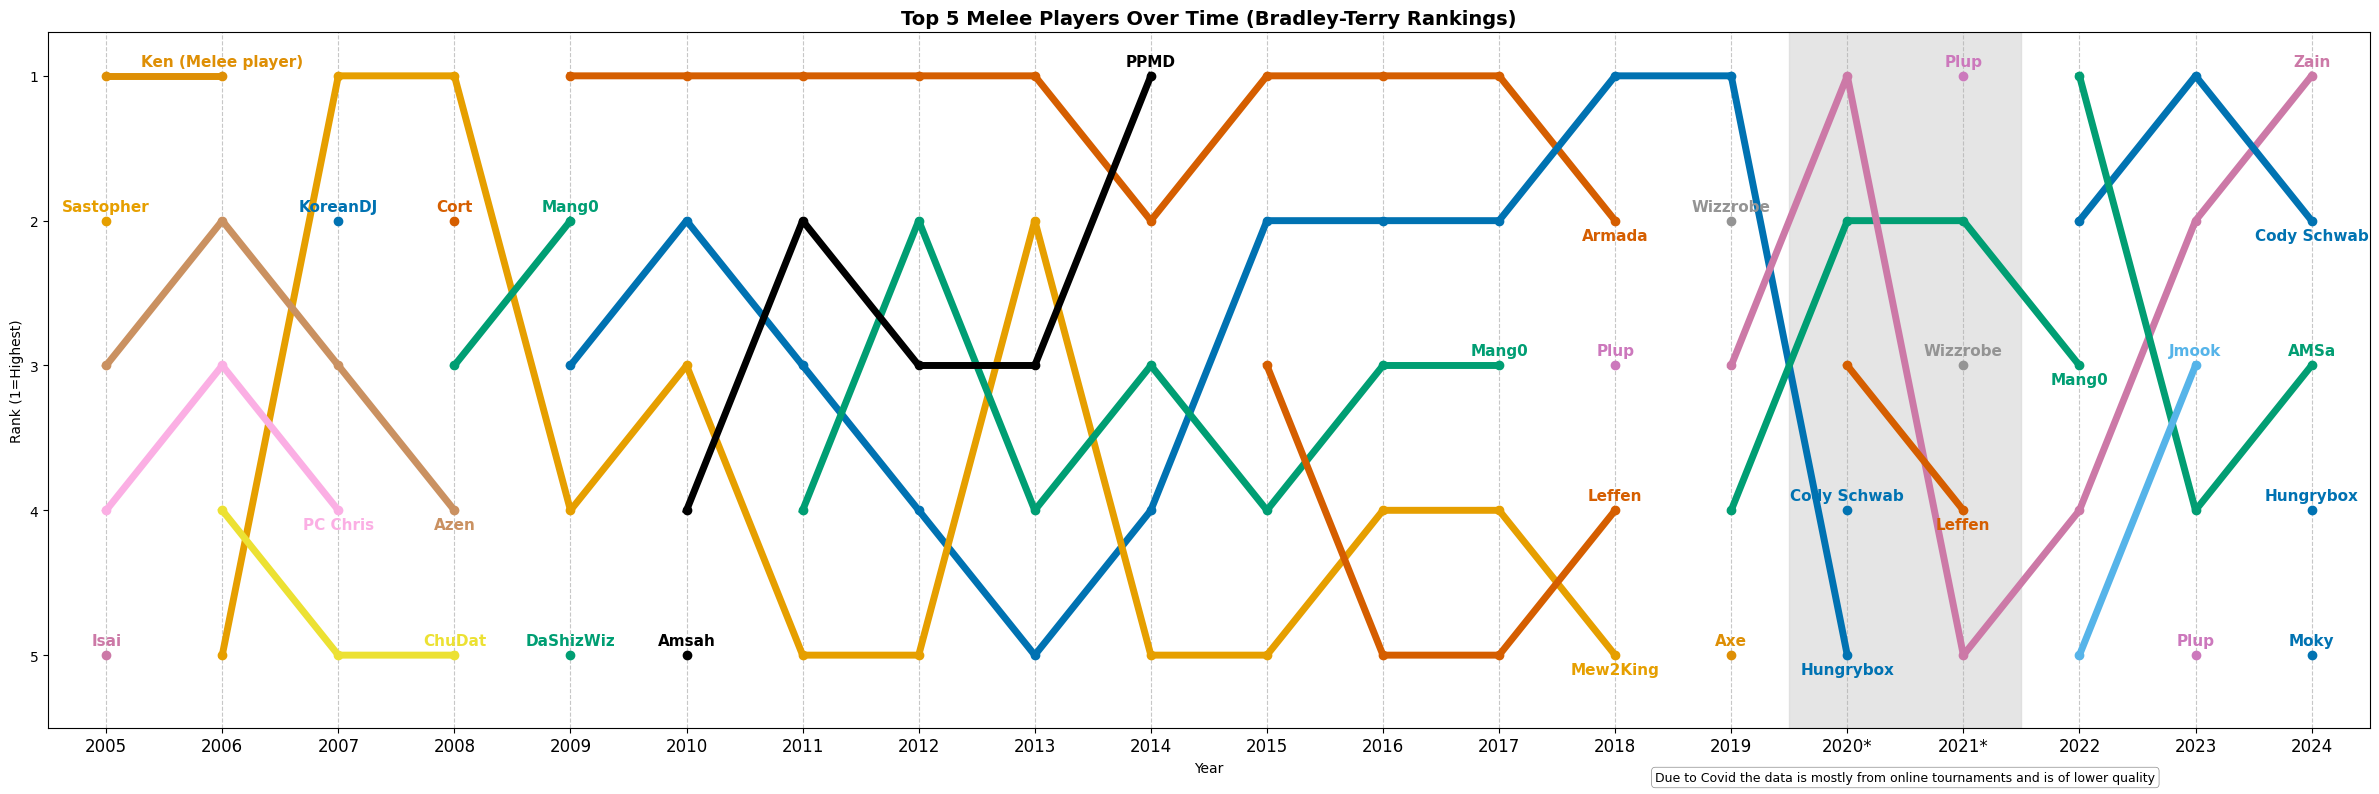

In [8]:
plot_bump_chart(pd.concat(all_results, ignore_index=True))

### Leaderboard Visualization
We can plot the ratings and confidence intervals and recover a ranking of teams using all 72,000 games from NBA history.

In [9]:
def convert_dict_to_plotting_df(ranking_dict):
    data = []
    for year, players in ranking_dict.items():
        if players == ["No Official Ranking"]:
            data.append({"Competitor": f"Placeholder-{year}", "Year": year, "Rating": 0})
            continue
        for i, player in enumerate(players):
            rank = i + 1
            rating = 6 - rank
            if rank <= 5:
                data.append({"Competitor": player, "Year": year, "Rating": rating})
    df = pd.DataFrame(data)
    min_year = min(ranking_dict.keys())
    max_year = max(ranking_dict.keys())
    all_years_range = range(min_year, max_year + 1)
    all_years_df = pd.DataFrame({"Year": list(all_years_range)})
    df_all_years = all_years_df.merge(df, on="Year", how="left")
    df_all_years["Competitor"] = df_all_years["Competitor"].fillna(np.nan)
    df_all_years["Rating"] = df_all_years["Rating"].fillna(0)
    return df_all_years

In [10]:
# official rankings from SSBMRank and RetroSSBMRank
# https://liquipedia.net/smash/SSBMRank
# https://liquipedia.net/smash/RetroSSBMRank
official_rankings = {
    2005: ["Ken", "ChuDat", "Isai", "Azen", "Sastopher"],
    2006: ["Ken", "Azen", "PC Chris", "ChuDat", "KoreanDJ"],
    2007: ["Mew2King", "Ken", "KoreanDJ", "PC Chris", "ChuDat"],
    2008: ["Mew2King", "Mang0", "Cort", "Azen", "PC Chris"],
    2009: ["Mang0", "Armada", "Hungrybox", "Mew2King", "DaShizWiz"],
    2010: ["Hungrybox", "Mang0", "Armada", "Mew2King", "PPMD"],
    2011: ["Armada", "Mang0", "PPMD", "Hungrybox", "Mew2King"],
    2012: ["Armada", "PPMD", "Mang0", "Hungrybox", "Mew2King"],
    2013: ["Mang0", "Armada", "Mew2King", "PPMD", "Hungrybox"],
    2014: ["Mang0", "Armada", "PPMD", "Mew2King", "Hungrybox"],
    2015: ["Armada", "Hungrybox", "Leffen", "Mang0", "Mew2King"],
    2016: ["Armada", "Hungrybox", "Mang0", "Mew2King", "Leffen"],
    2017: ["Hungrybox", "Armada", "Mang0", "Mew2King", "Plup"],
    2018: ["Hungrybox", "Armada", "Leffen", "Plup", "Mang0"],
    2019: ["Hungrybox", "Leffen", "Mang0", "Axe", "Wizzrobe"],
    2022: ["Zain", "aMSa", "Mang0", "Cody Schwab", "Hungrybox"],
    2023: ["Cody Schwab", "Zain", "Jmook", "moky", "Plup"],
    2024: ["Zain", "Cody Schwab", "Mang0", "moky", "Jmook"],
}

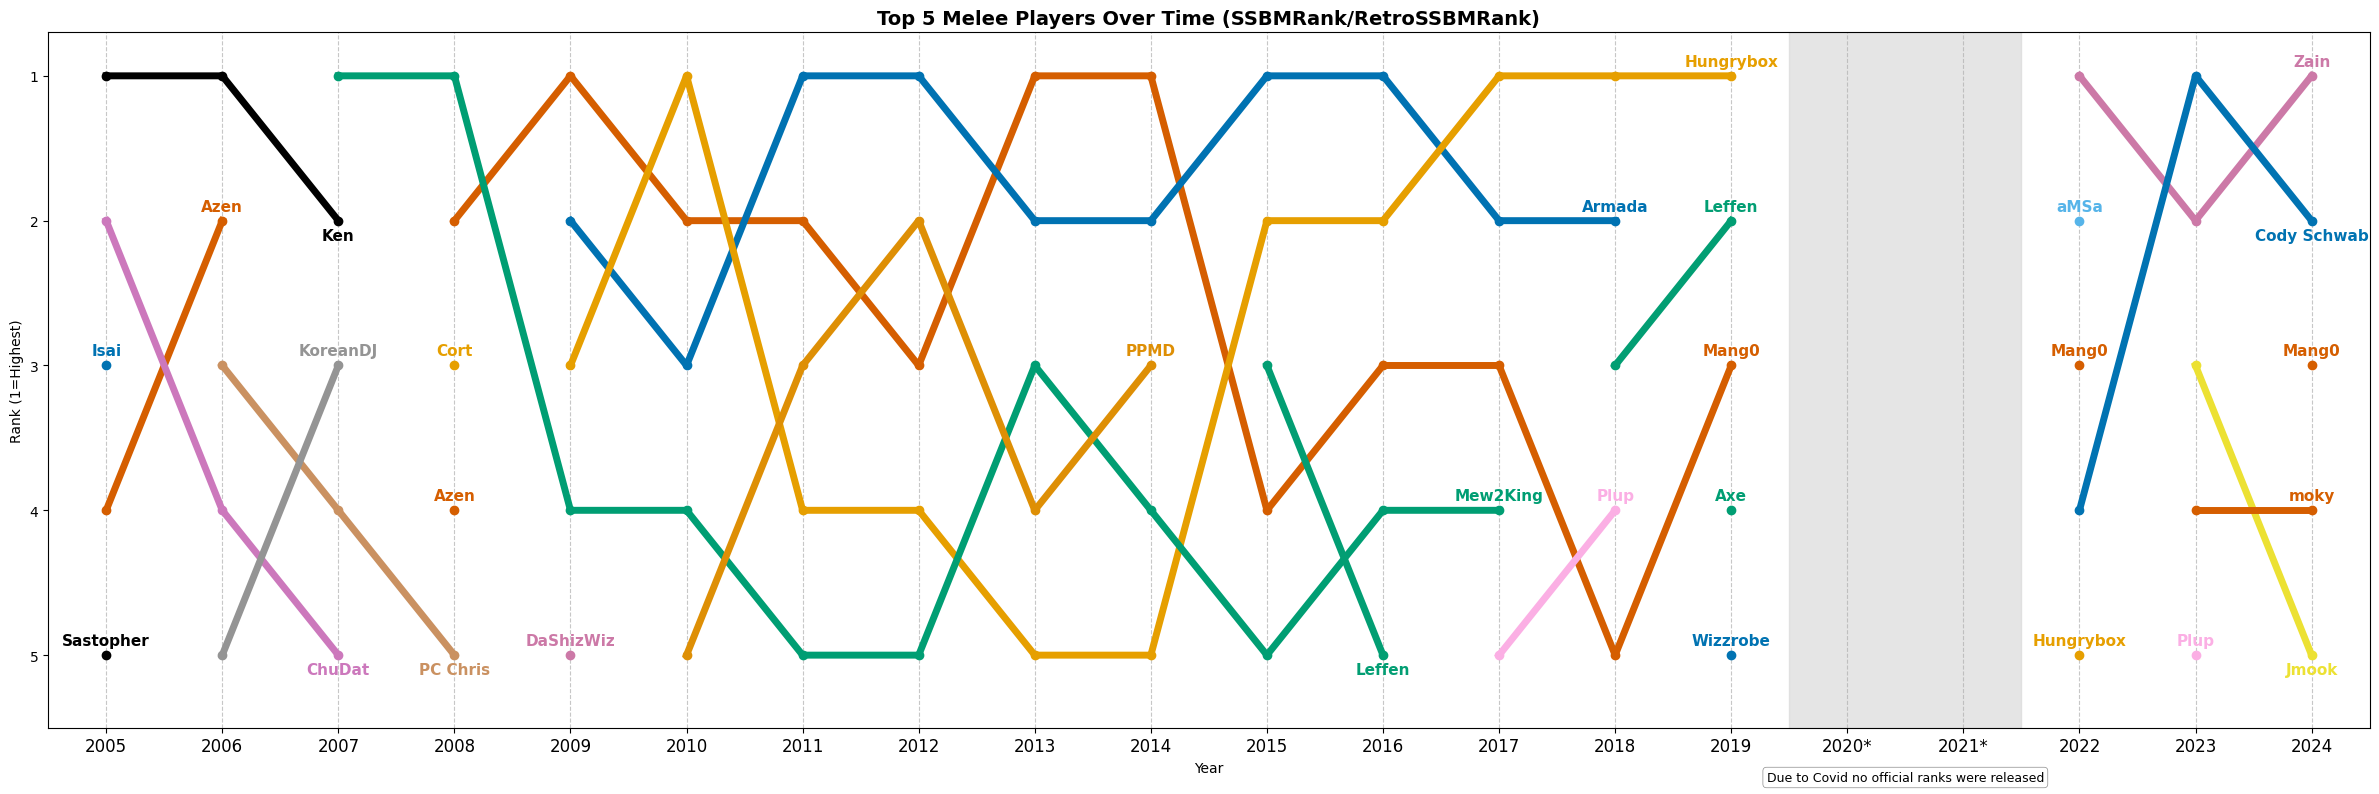

In [11]:
plot_bump_chart(convert_dict_to_plotting_df(official_rankings), "official")

# Ranking Comparisons
* For 12 out of 18 years with SSBMRank or RetroSSBMRank, the BT ranking agree on the first place ranking! (2005, 2006, 2007, 2008, 2011, 2012, 2015, 2016, 2018, 2019, 2023, 2024)
* For some years like 2015 and 2016, the top 5 completely agree, and for 2023 4/5 are in the same places.
* One player consistently rated higher by the human experts compared to the purely outcome based ranking is Mango, who is a player known for being extremely good, but also for sandbagging and playing non-optimal characters on purpose and losing to lower ranked players. Often the ranking panelists will discount these results by saying "he wasn't really trying" but the Bradley-Terry model is not as forgiving and this cost him several years at #1.

It would be interesting to re-run these results, limited to the same list of major tournaments used by the official ranking panel and discounting events where top players are known to have "sandbagged". But this example is a proof on concept for data driven rankings in esports and it's powered by the general purpose `arena` python package.